# Experiments with tag `leios-2025w08`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
})

## Read results

### IB production

In [2]:
ibs <- mongo(url="mongodb://thelio", db="leios", collection="ibs")$find() %>% data.table
ibs <- ibs[order(`time_s`)]
ibs[, `size_bytes`:=as.numeric(`size_bytes`)]
ibs %>% summary

      ib               scenario        size_bytes         time_s      
 Length:32699       Min.   :  1.00   Min.   :102704   Min.   :  0.13  
 Class :character   1st Qu.: 30.00   1st Qu.:102704   1st Qu.: 37.13  
 Mode  :character   Median : 50.00   Median :102704   Median : 75.13  
                    Mean   : 63.17   Mean   :102704   Mean   : 75.22  
                    3rd Qu.:100.00   3rd Qu.:102704   3rd Qu.:113.13  
                    Max.   :100.00   Max.   :102704   Max.   :149.13  

### Elapsed time for receipt of IBs

In [3]:
ibsElapsed <- mongo(url="mongodb://thelio", db="leios", collection="ibsElapsed")$find() %>% data.table
ibsElapsed <- ibsElapsed[order(`scenario`, `time_s`)]
ibsElapsed %>% summary

   elapsed_s             ib                 node          scenario     
 Min.   :  0.1055   Length:2590825     Min.   : 0.00   Min.   :  1.00  
 1st Qu.:  1.6512   Class :character   1st Qu.:24.00   1st Qu.: 30.00  
 Median :  2.8765   Mode  :character   Median :49.00   Median : 50.00  
 Mean   : 11.4269                      Mean   :49.28   Mean   : 55.29  
 3rd Qu.: 13.4552                      3rd Qu.:74.00   3rd Qu.:100.00  
 Max.   :119.7090                      Max.   :99.00   Max.   :100.00  
     time_s        
 Min.   :  0.2355  
 1st Qu.: 39.0032  
 Median : 76.4314  
 Mean   : 76.3944  
 3rd Qu.:113.8115  
 Max.   :149.9999  

## Diagnostics

### Check that the IB production rate is close to expectations

In [4]:
ibs[, .(`Actual IBs`=.N, `Duration`=max(`time_s`)), by=(`scenario`)][, .(`scenario`, `Actual IBs`, `Expected IBs`=`Duration`*`scenario`)]

scenario,Actual IBs,Expected IBs
<dbl>,<int>,<dbl>
1,139,148.13
2,319,298.26
3,474,447.39
5,746,745.65
10,1463,1491.30
20,2934,2982.60
30,4402,4473.90
50,7355,7456.50
100,14867,14913.00


### Check the linearity and slope of cumulative IB production

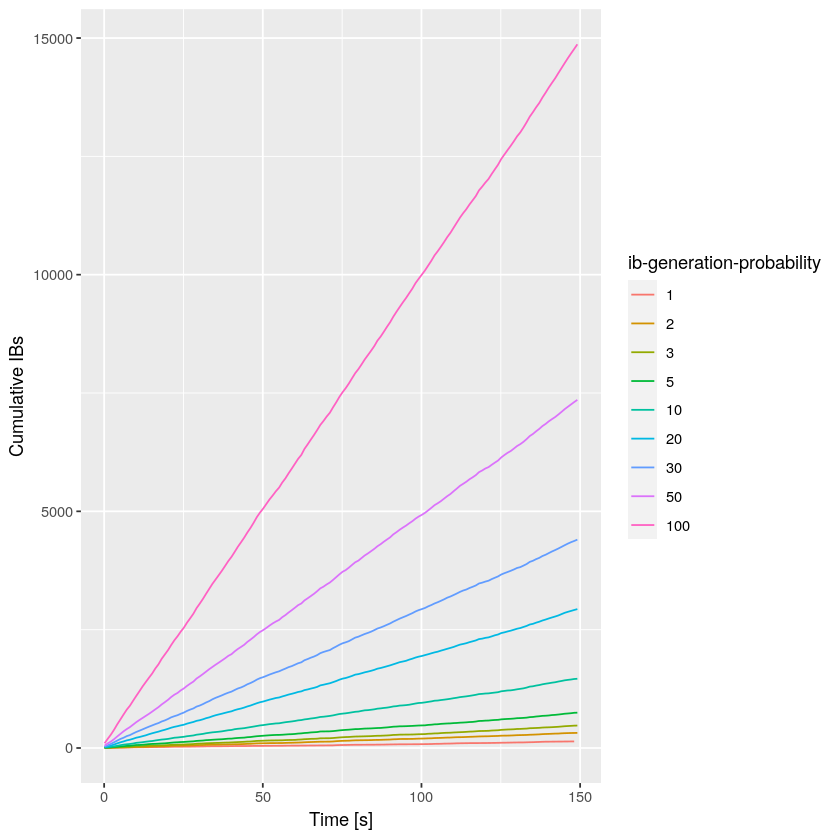

In [5]:
ggplot(
    ibs[`scenario` >= 0.5, .(`IBs`=.N), by=.(`ib-generation-probability`=factor(`scenario`), `time_s`)][, .(`time_s`, `Cumulative IBs`=cumsum(`IBs`)), by=.(`ib-generation-probability`)],
    aes(x=`time_s`, y=`Cumulative IBs`, color=`ib-generation-probability`)
) +
  geom_line() +
  xlab("Time [s]")

### Examine the spread in elapsed times as the IB generation rate increases

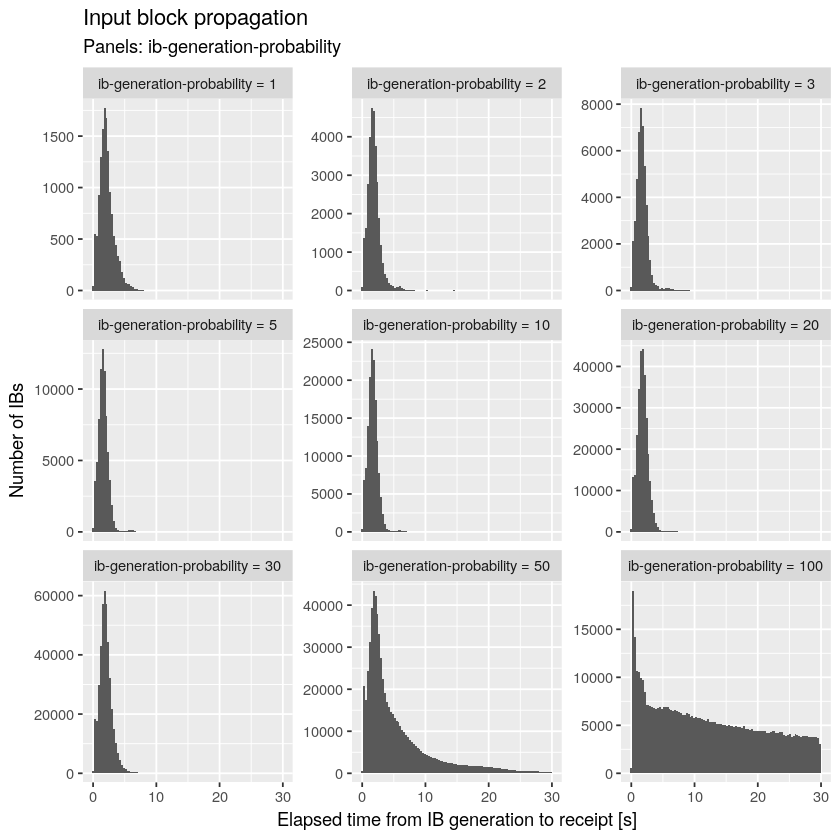

In [6]:
ggplot(ibsElapsed[`elapsed_s` <= 30, .(
    `scenario`=factor(paste("ib-generation-probability =", `scenario`), levels=paste("ib-generation-probability =", ibsElapsed[, unique(`scenario`)])),
    `elapsed_s`
)], aes(x=`elapsed_s`)) +
  geom_histogram(bins=100) +
  facet_wrap(. ~ `scenario`, scales="free_y") +
  xlab("Elapsed time from IB generation to receipt [s]") +
  ylab("Number of IBs") +
  ggtitle("Input block propagation", subtitle="Panels: ib-generation-probability")

In [7]:
ggsave("ibelapsed-histogram.png", width=8, height=6, units="in", dpi=150)

### Take a closer look at outliers in IB elapsed time

#### Full dataset

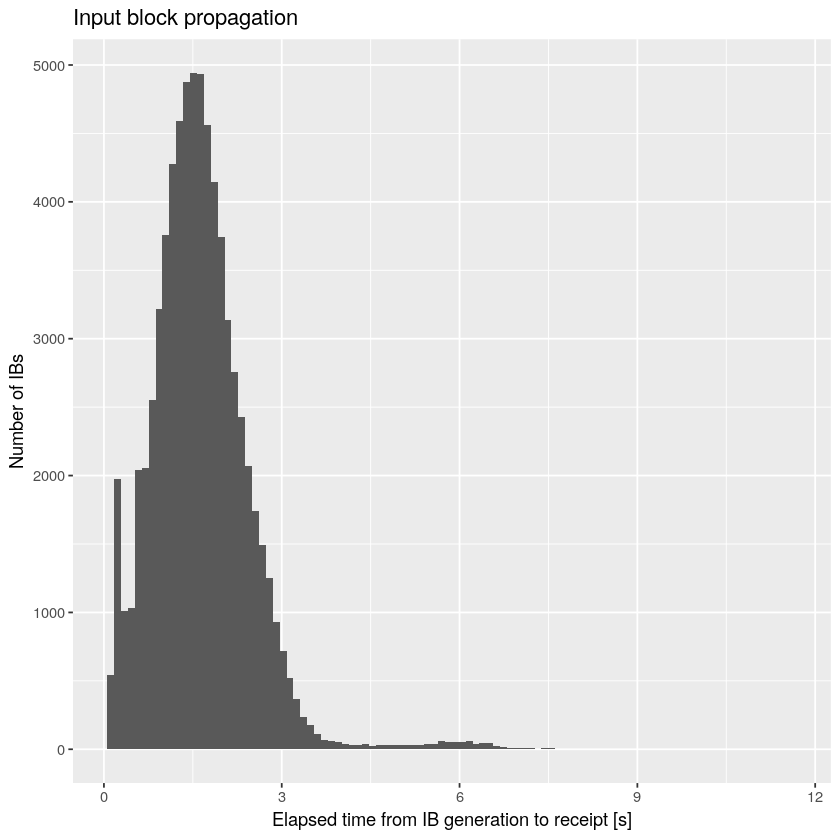

In [8]:
ggplot(ibsElapsed[`scenario` == 5], aes(x=`elapsed_s`)) +
  geom_histogram(bins=100) +
  xlab("Elapsed time from IB generation to receipt [s]") +
  ylab("Number of IBs") +
  ggtitle("Input block propagation")

#### Zoom in

Warning message:
“Removed 31 rows containing missing values (`geom_bar()`).”


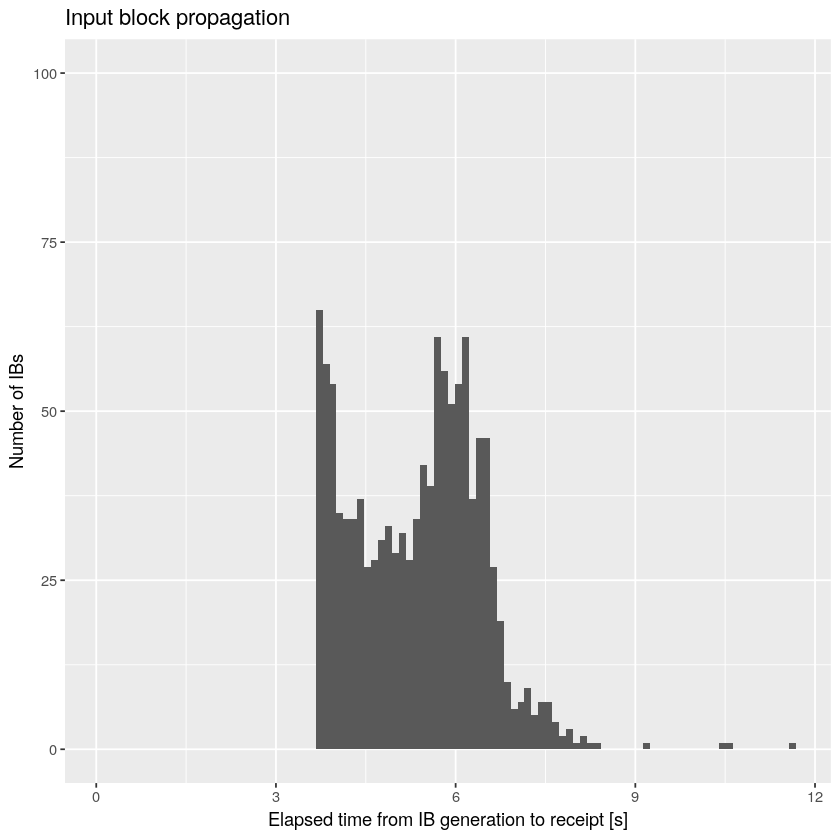

In [9]:
ggplot(ibsElapsed[`scenario` == 5], aes(x=`elapsed_s`)) +
  geom_histogram(bins=100) +
  ylim(0, 100) +
  xlab("Elapsed time from IB generation to receipt [s]") +
  ylab("Number of IBs") +
  ggtitle("Input block propagation")

#### Check for stationarity

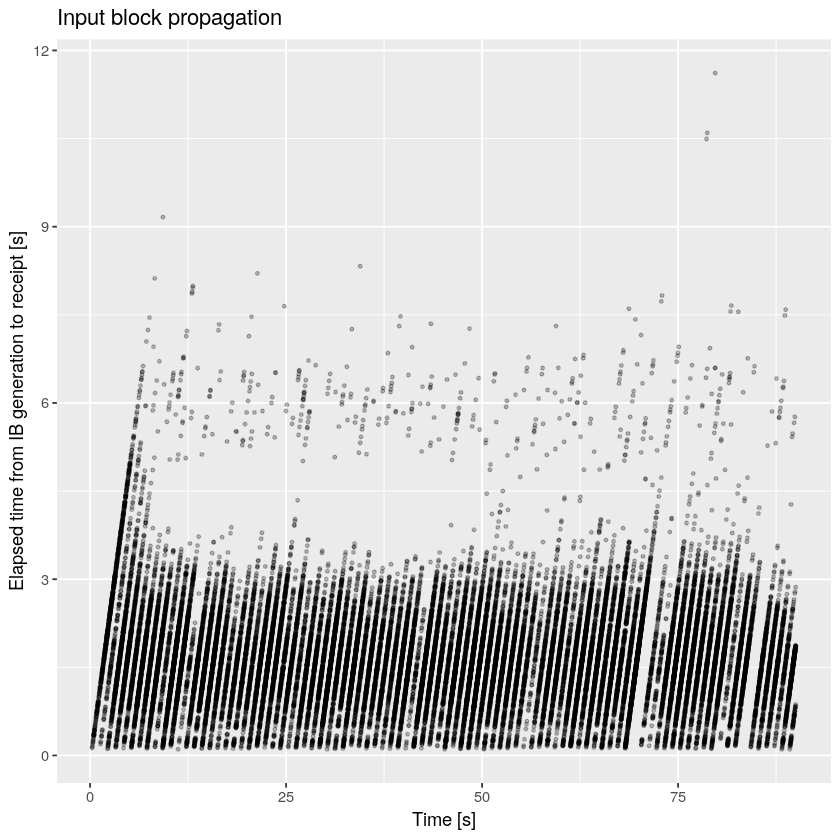

In [10]:
ggplot(ibsElapsed[`scenario` == 5 & `time_s` <= 90], aes(x=`time_s`, y=`elapsed_s`)) +
  geom_point(size=0.75, alpha=0.25) +
  xlab("Time [s]") +
  ylab("Elapsed time from IB generation to receipt [s]") +
  ggtitle("Input block propagation")

## Fraction of IBs received by end of simulation

In [11]:
ibsPerformance <- ibsElapsed[, .(
    `scenario`,
    `time_s`,
    `Received IBs`=as.numeric(.N)
), by=.(`scenario`, `ib`)][, .(
    `Sent IBs`=as.numeric(.N),
    `Received IBs`=sum(`Received IBs`)
), by=.(`scenario`, `time_s`)][, .(
    `Received [%]`=100*sum(`Received IBs`)/sum(`Sent IBs`)/99
), by=.(`scenario`,`time_s`)]

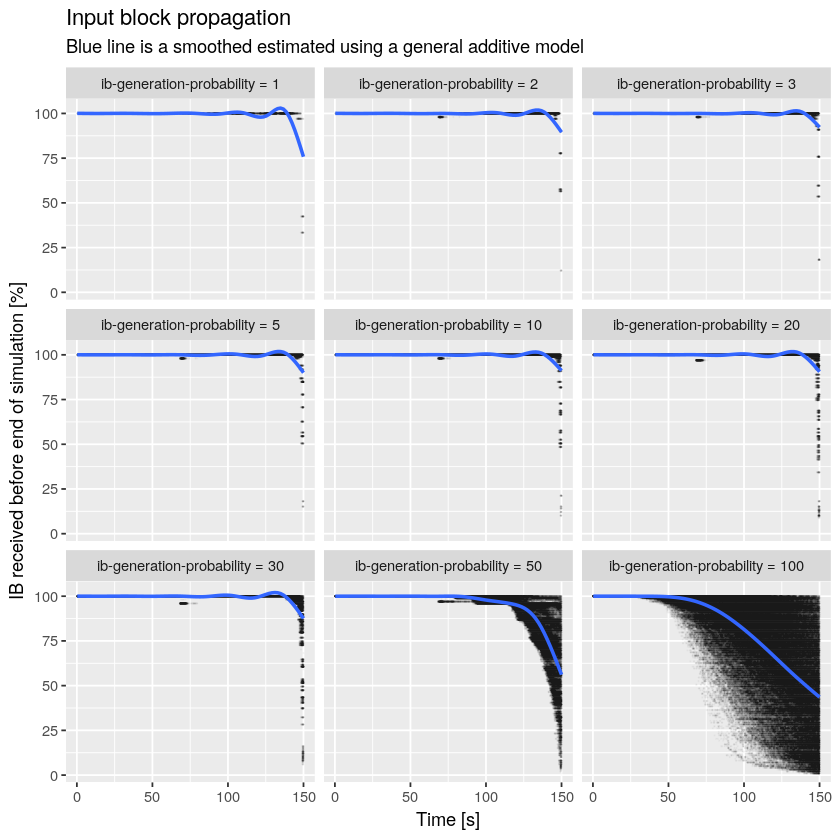

In [12]:
ggplot(
    ibsPerformance[, .(
        `scenario`=factor(paste("ib-generation-probability =", `scenario`), levels=paste("ib-generation-probability =", ibsElapsed[, unique(`scenario`)])),
        `time_s`, 
        `Received [%]`
    )], 
    aes(x=`time_s`, y=`Received [%]`)
) +
  geom_point(size=0.05, alpha=0.02) +
  geom_smooth(formula=y ~ s(x, bs = "cs"), method="gam") +
  facet_wrap(. ~ `scenario`) +
  xlab("Time [s]") +
  ylab("IB received before end of simulation [%]") +
  ggtitle("Input block propagation", subtitle="Blue line is a smoothed estimated using a general additive model")

In [13]:
ggsave("ibperformance-end.png", width=8, height=6, units="in", dpi=150)

## Fraction of IBs received within five seconds

In [14]:
ibsPerformance <- ibsElapsed[`elapsed_s` <= 5, .(
    `scenario`,
    `time_s`,
    `Received IBs`=as.numeric(.N)
), by=.(`scenario`, `ib`)][, .(
    `Sent IBs`=as.numeric(.N),
    `Received IBs`=sum(`Received IBs`)
), by=.(`scenario`, `time_s`)][, .(
    `Received [%]`=100*sum(`Received IBs`)/sum(`Sent IBs`)/99
), by=.(`scenario`,`time_s`)]

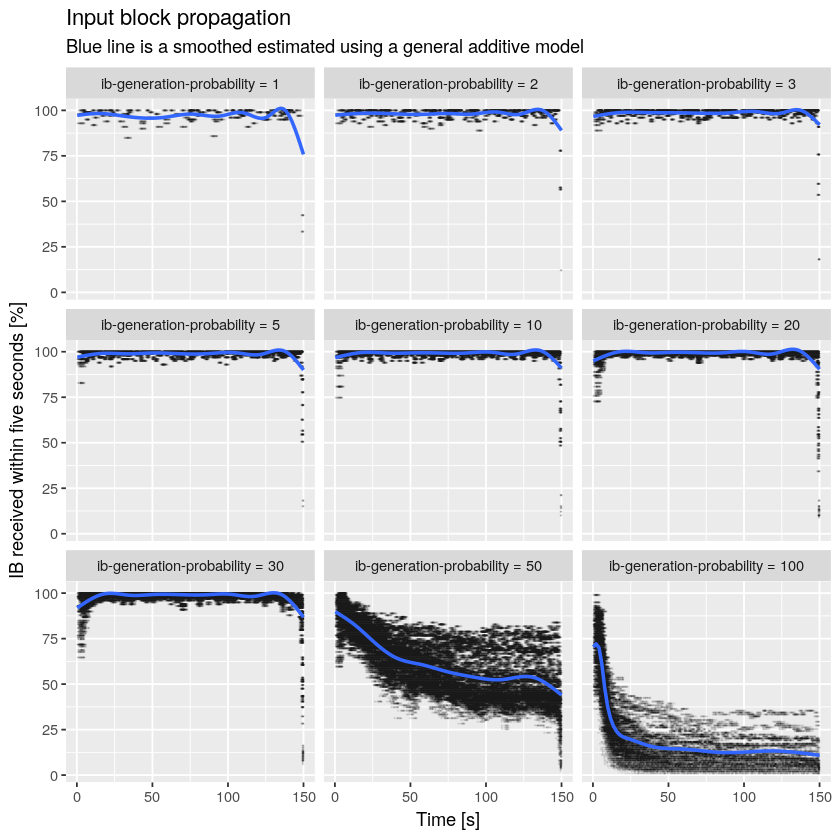

In [15]:
ggplot(
    ibsPerformance[, .(
        `scenario`=factor(paste("ib-generation-probability =", `scenario`), levels=paste("ib-generation-probability =", ibsElapsed[, unique(`scenario`)])),
        `time_s`, 
        `Received [%]`
    )], 
    aes(x=`time_s`, y=`Received [%]`)
) +
  geom_point(size=0.05, alpha=0.02) +
  geom_smooth(formula=y ~ s(x, bs = "cs"), method="gam") +
  facet_wrap(. ~ `scenario`) +
  xlab("Time [s]") +
  ylab("IB received within five seconds [%]") +
  ggtitle("Input block propagation", subtitle="Blue line is a smoothed estimated using a general additive model")

In [16]:
ggsave("ibperformance-5s.png", width=8, height=6, units="in", dpi=150)